In [1]:
# Add PATH (adapt!)
push!(LOAD_PATH, "/Volumes/cfranken/code/gitHub/Land/src/");
#push!(LOAD_PATH, "/Volumes/cfranken/code/gitHub/Land/src/Utils/");
#push!(LOAD_PATH, "/Volumes/cfranken/code/gitHub/LSM-SPAM/src/tools/");

# Use Plots:
using Plots
#using PhotoStructs
pyplot()

Plots.PyPlotBackend()

In [2]:
using Revise
using Land
using BenchmarkTools
using Statistics
using Parameters

┌ Info: Precompiling Land [27e3c115-2cb8-4114-b7a5-cd9f011f9dcc]
└ @ Base loading.jl:1260
┌ Warning: Package CodecZlib does not have Libdl in its dependencies:
│ - If you have CodecZlib checked out for development and have
│   added Libdl as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with CodecZlib
└ Loading Libdl into CodecZlib from project dependency, future warnings for CodecZlib are suppressed.
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for MAT [23992714-dd62-5051-b70f-ba57cb901cac]
│   exception = Required dependency CodecZlib [944b1d66-785c-5afd-91f1-9de20f533193] failed to load from a cache file.
└ @ Base loading.jl:1041
┌ Warning: Package CodecZlib does not have Libdl in its dependencies:
│ - If you have CodecZlib checked out for development and have
│   added Libdl as a dependency but haven't updated your primary
│   environment's man

Reading Optical Parameters from 400.0 to 2380.0 length: 115


┌ Warning: The call to compilecache failed to create a usable precompiled cache file for Land [27e3c115-2cb8-4114-b7a5-cd9f011f9dcc]
│   exception = ErrorException("Required dependency CodecZlib [944b1d66-785c-5afd-91f1-9de20f533193] failed to load from a cache file.")
└ @ Base loading.jl:1041
┌ Info: Precompiling MAT [23992714-dd62-5051-b70f-ba57cb901cac]
└ @ Base loading.jl:1260
┌ Warning: Package CodecZlib does not have Libdl in its dependencies:
│ - If you have CodecZlib checked out for development and have
│   added Libdl as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with CodecZlib
└ Loading Libdl into CodecZlib from project dependency, future warnings for CodecZlib are suppressed.
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for MAT [23992714-dd62-5051-b70f-ba57cb901cac]
│   exception = ErrorException("Required dependency CodecZlib [944b1d

Reading Optical Parameters from 400.0 to 2380.0 length: 115


In [43]:
@unpack CanopyRTMod = Land
@unpack FT,leafbio, canopy, angles, canOpt, canRad,sunRad,soil = Land.CanopyRTMod

Land.CanopyRTMod

In [44]:
wl = CanopyRTMod.wl;
wle = CanopyRTMod.wle;
wlf = CanopyRTMod.wlf;


In [45]:
#@time CanopyRTMod.optis.nr[3:20] .= 2

In [46]:
leaf = leafbio{FT, length(wl), length(wle), length(wlf),length(wle)*length(wlf)}();


In [47]:
using Parameters
@unpack N, Cab, Car, Ant, Cs, Cw, Cm, ρ_SW, τ_SW = CanopyRTMod.leaf;

In [48]:
@btime CanopyRTMod.fluspect!(CanopyRTMod.leaf, CanopyRTMod.optis);

  641.522 μs (2992 allocations: 995.05 KiB)


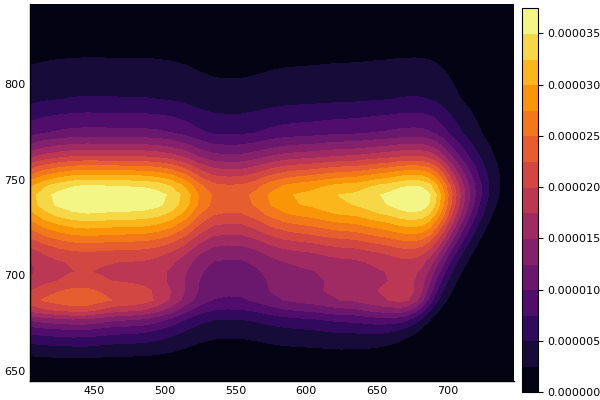

In [49]:
contourf(wle, wlf, CanopyRTMod.leaf.Mb)

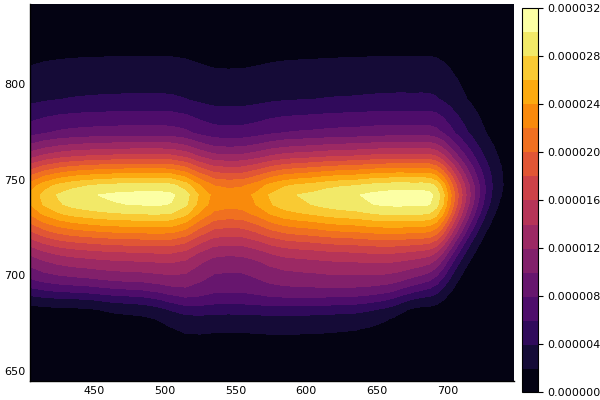

In [50]:
contourf(wle, wlf, CanopyRTMod.leaf.Mf)

In [51]:
arrayOfLeaves = Array{leafbio{FT,length(wl), length(wle), length(wlf),length(wle)*length(wlf)}, 1}(undef, CanopyRTMod.canopy.nlayers)
for i = 1:CanopyRTMod.canopy.nlayers
    #@show i
    arrayOfLeaves[i] = leafbio{FT, length(wl), length(wle), length(wlf),length(wle)*length(wlf)}()
    CanopyRTMod.fluspect!(arrayOfLeaves[i], CanopyRTMod.optis)
end

In [87]:
CanopyRTMod.angles.tto=-88
CanopyRTMod.angles.psi=50
@time CanopyRTMod.computeCanopyGeomProps!(canopy, angles,canOpt);
@time CanopyRTMod.computeCanopyMatrices!(arrayOfLeaves,canOpt);
@time CanopyRTMod.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRTMod.soil);
CanOpt2 = deepcopy(canOpt)
@time CanopyRTMod.computeSIF_Fluxes!(arrayOfLeaves, canOpt, canRad, canopy, CanopyRTMod.soil);

  3.929945 seconds (5.62 M allocations: 228.181 MiB, 2.08% gc time)
  8.182070 seconds (69.74 M allocations: 2.347 GiB, 19.14% gc time)
 65.577566 seconds (88.31 M allocations: 3.069 GiB, 2.26% gc time)
 57.403706 seconds (86.59 M allocations: 3.034 GiB, 2.52% gc time)


In [88]:
# Just a test
@time CanopyRTMod.compCanopyOptsExact!(arrayOfLeaves,canOpt, canopy.lidf);

  1.406561 seconds (48.44 M allocations: 741.563 MiB, 24.20% gc time)


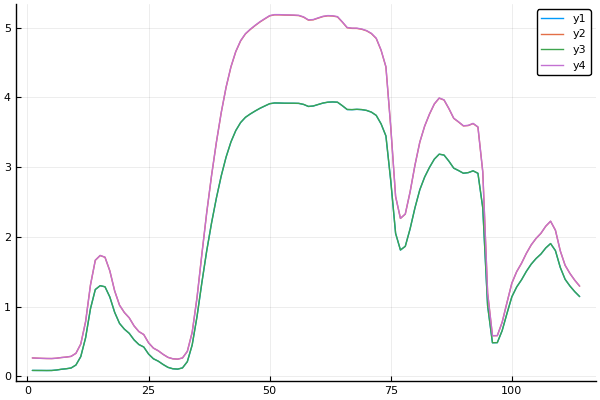

In [89]:
plot(CanOpt2.w[:,10])
plot!(CanOpt2.vb[:,1])
plot!(canOpt.w[:,1]/36)
plot!(canOpt.vb[:,1]/36)

In [90]:
CanopyRTMod.soil.albedo_SW[:] .=0.2;

In [91]:
reflVIS = []
reflNIR = []
SIF_FR = []
SIF_FR1 = []
SIF_FR2 = []
SIF_FR3 = []
SIF_FR4 = []
SIF_R1 = []
SIF_R2 = []
SIF_R3 = []
SIF_R4 = []
SIF_R  = []
Pso = []
Po = []
Ps = []
ko = []
CanopyRTMod.angles.tts=30
CanopyRTMod.angles.psi=0
CanopyRTMod.canopy.LAI = 3
for VZA=-89.5:0.5:89.5
    CanopyRTMod.angles.tto=VZA
    CanopyRTMod.computeCanopyGeomProps!(canopy, angles,canOpt);
    CanopyRTMod.computeCanopyMatrices!(arrayOfLeaves,canOpt);
    CanopyRTMod.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRTMod.soil);
    CanopyRTMod.computeSIF_Fluxes!(arrayOfLeaves, canOpt, canRad, canopy, CanopyRTMod.soil);
    push!(reflVIS, canRad.alb_obs[28])
    push!(reflNIR, canRad.alb_obs[52])
    push!(SIF_R , canRad.SIF_obs[8])
    push!(SIF_FR, canRad.SIF_obs[20])
    push!(SIF_FR1, canRad.SIF_obs_sunlit[20])
    push!(SIF_FR2, canRad.SIF_obs_scattered[20])
    push!(SIF_FR3, canRad.SIF_obs_soil[20])
    push!(SIF_FR4, canRad.SIF_obs_shaded[20])
    push!(SIF_R1, canRad.SIF_obs_sunlit[8])
    push!(SIF_R2, canRad.SIF_obs_scattered[8])
    push!(SIF_R3, canRad.SIF_obs_soil[8])
    push!(SIF_R4, canRad.SIF_obs_shaded[8])
    push!(Pso, canOpt.Pso[1])
    push!(Ps, canOpt.Ps[1])
    push!(Po, canOpt.Po[1])
    push!(ko, canOpt.ko[1])
end

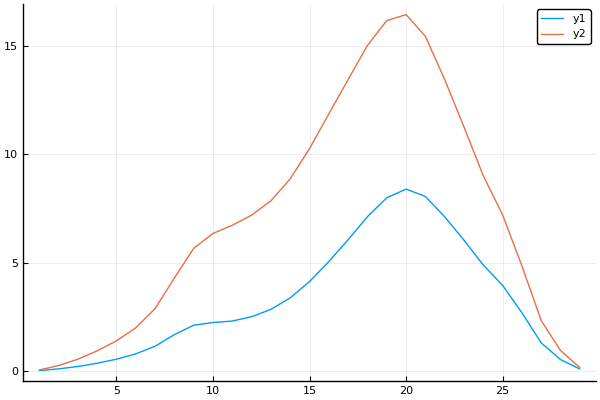

In [92]:
CanopyRTMod.angles.tto=89
CanopyRTMod.computeCanopyGeomProps!(canopy, angles,canOpt);
CanopyRTMod.computeCanopyMatrices!(arrayOfLeaves,canOpt);
CanopyRTMod.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRTMod.soil);
CanopyRTMod.computeSIF_Fluxes!(arrayOfLeaves, canOpt, canRad, canopy, CanopyRTMod.soil);
plot(canRad.SIF_hemi)
plot!(canRad.SIF_sum)

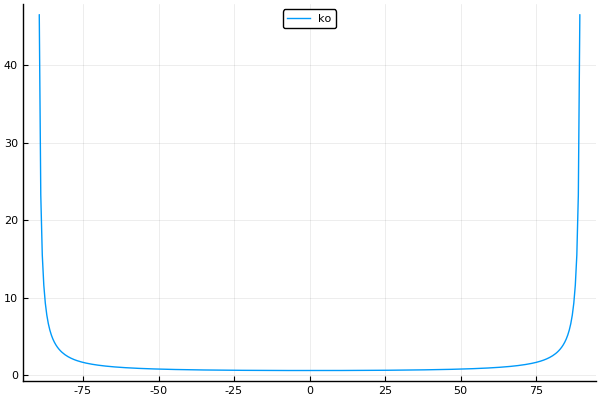

In [93]:
VZA=-89.5:0.5:89.5
plot(VZA, ko, label="ko")

wl[28] = 662.0f0
wl[52] = 817.0f0


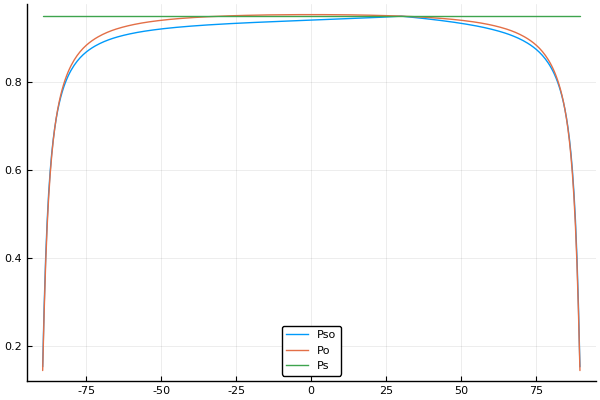

In [94]:
@show wl[28]
@show wl[52]
CanopyRTMod.angles.tts = 48

plot(VZA, Pso, label="Pso")
plot!(VZA, Po, label="Po")
plot!(VZA, Ps, label="Ps")
#@show wlf

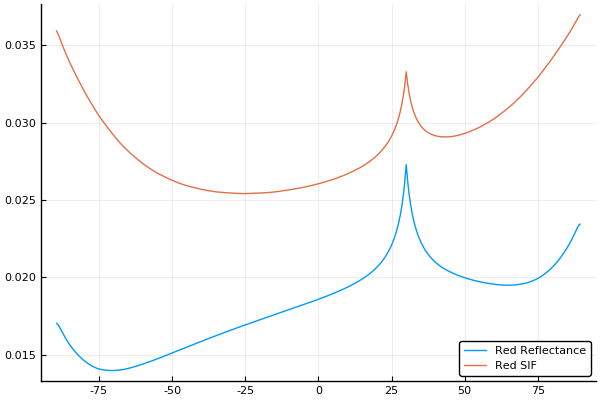

In [95]:

plot(VZA, reflVIS, label="Red Reflectance")
plot!(VZA, SIF_FR/100, label="Red SIF")

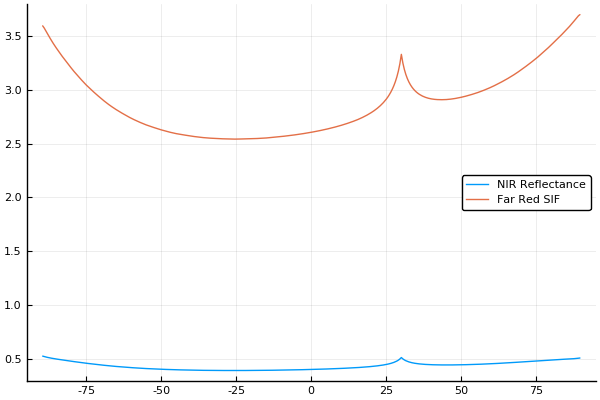

In [96]:
plot(VZA, reflNIR, label="NIR Reflectance")
plot!(VZA, SIF_FR, label="Far Red SIF")

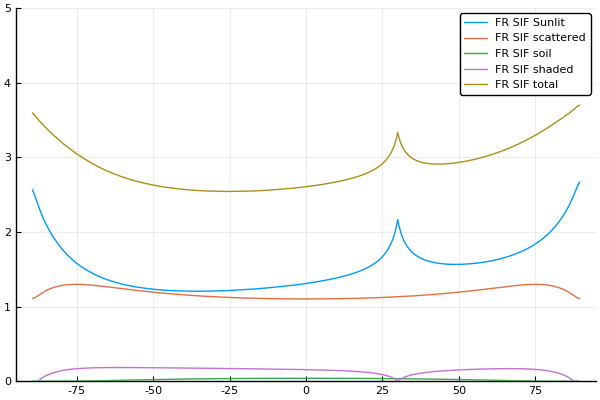

In [97]:
plot(VZA, SIF_FR1, label="FR SIF Sunlit")
plot!(VZA, SIF_FR2, label="FR SIF scattered")
plot!(VZA, SIF_FR3, label="FR SIF soil")
plot!(VZA, SIF_FR4, label="FR SIF shaded")
plot!(VZA, SIF_FR, label="FR SIF total")
ylims!(0,5)

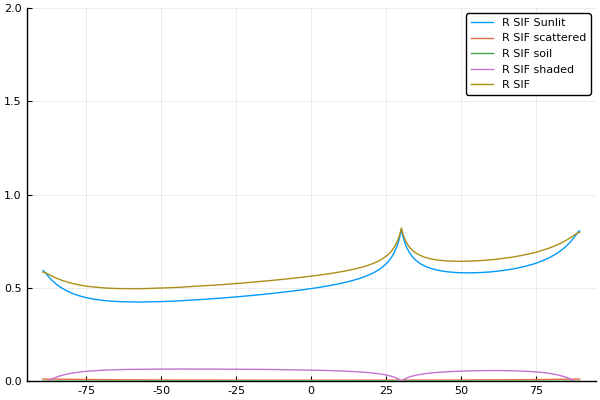

In [98]:
plot(VZA, SIF_R1, label="R SIF Sunlit")
plot!(VZA, SIF_R2, label="R SIF scattered")
plot!(VZA, SIF_R3, label="R SIF soil")
plot!(VZA, SIF_R4, label="R SIF shaded")
plot!(VZA, SIF_R, label="R SIF ")
ylims!(0,2)

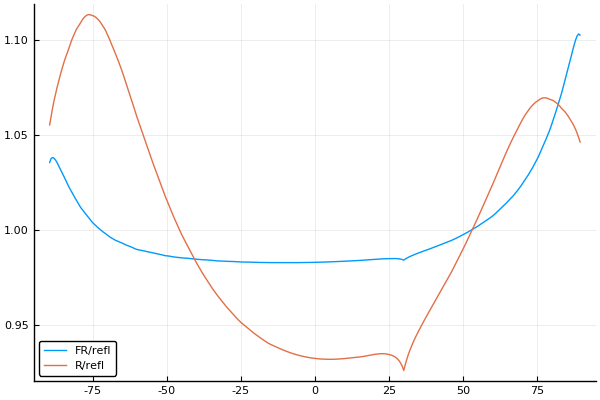

In [99]:
plot(VZA, SIF_FR./reflNIR./mean(SIF_FR./reflNIR), label="FR/refl")
plot!(VZA, SIF_R./reflVIS./mean(SIF_R./reflVIS), label="R/refl")
#plot!(VZA, , label="Far Red SIF")

In [100]:
CanopyRTMod.soil.albedo_SW[:] .=0.2;
reflRed_SZA = []
reflNIR_SZA = []
CanopyRTMod.canopy.Ω = 1.0
CanopyRTMod.angles.tto=0.2
CanopyRTMod.canopy.LAI=2.
for SZA=0.0:1:75
    CanopyRTMod.angles.tts=SZA
    CanopyRTMod.computeCanopyGeomProps!(canopy, angles,canOpt);
    CanopyRTMod.computeCanopyMatrices!(arrayOfLeaves,canOpt);
    CanopyRTMod.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRTMod.soil);
    push!(reflRed_SZA, canRad.alb_direct[28])
    push!(reflNIR_SZA, canRad.alb_direct[52])
end

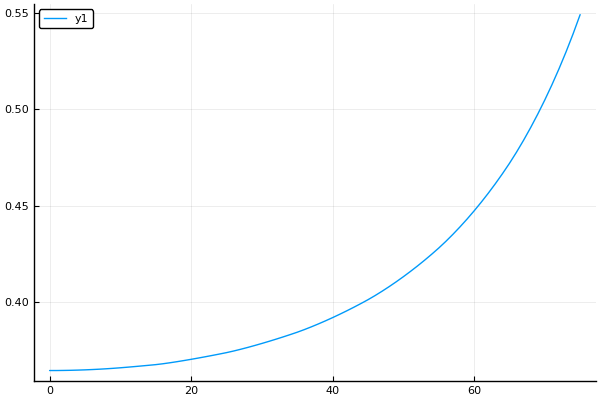

In [101]:
SZA=0:1:75
plot(SZA, reflNIR_SZA)

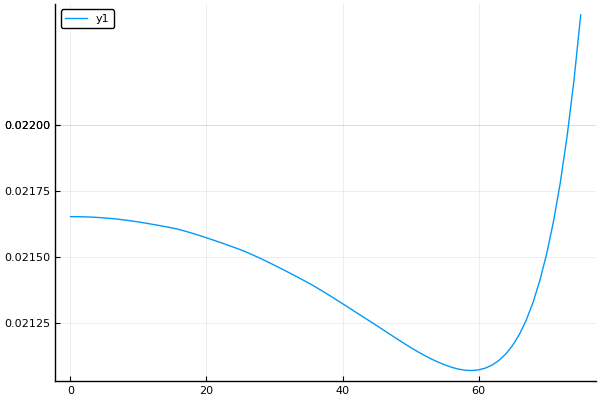

In [102]:
SZA=0:1:75
plot(SZA, reflRed_SZA)

In [103]:
# Test plots from Christiaan's papers

In [104]:
reflVIS = Float32[]
reflNIR = Float32[]
SIF_FR = Float32[]
SIF_R  = Float32[]
CanopyRTMod.angles.tts=48
CanopyRTMod.angles.psi=0
CanopyRTMod.canopy.LAI=3.22
for psi=0:360
    CanopyRTMod.angles.psi=psi
    for VZA=0:1:85
        CanopyRTMod.angles.tto=VZA

        CanopyRTMod.computeCanopyGeomProps!(canopy, angles,canOpt);
        CanopyRTMod.computeCanopyMatrices!(arrayOfLeaves,canOpt);
        CanopyRTMod.RTM_SW!(canopy, canOpt, canRad,sunRad, CanopyRTMod.soil);
        CanopyRTMod.computeSIF_Fluxes!(arrayOfLeaves, canOpt, canRad, canopy, CanopyRTMod.soil);
        push!(reflVIS, canRad.alb_obs[28])
        push!(reflNIR, canRad.alb_obs[52])
        push!(SIF_R , canRad.SIF_obs[8])
        push!(SIF_FR, canRad.SIF_obs[20])
    end
end

In [105]:
A = reshape(reflNIR, ( 86,361));
B = reshape(reflVIS, ( 86,361));
SIFFER = reshape(SIF_R, ( 86,361));
SIFFER_FR = reshape(SIF_FR, ( 86,361));

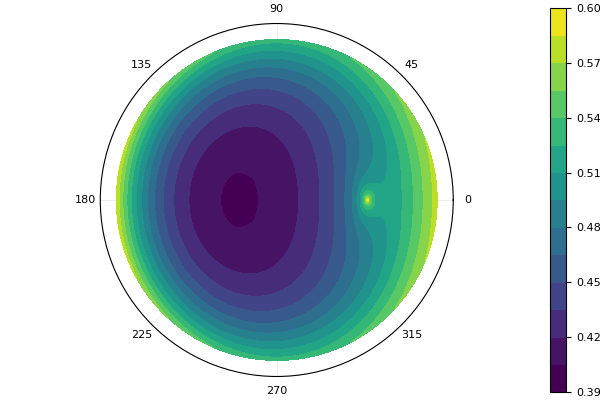

In [106]:
using Plots; pyplot()

#heatmap(A, cmap=)
hm = contourf(deg2rad.(collect((0:360))),collect(0:1:85),  A,  proj=:polar, color=:viridis, alpha=0.5)

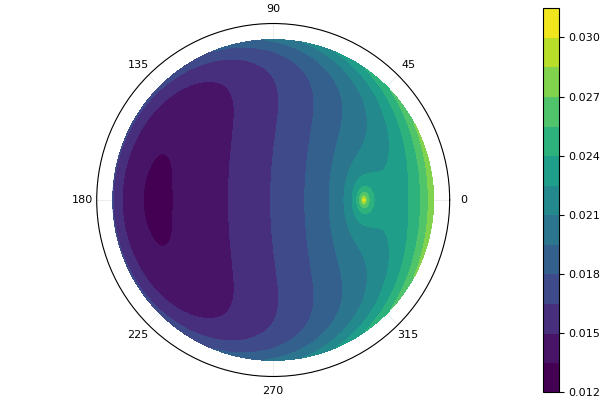

In [107]:
#heatmap(A, cmap=)
hm = contourf(deg2rad.(collect((0:360))),collect(0:1:85),  B,  proj=:polar, color=:viridis)

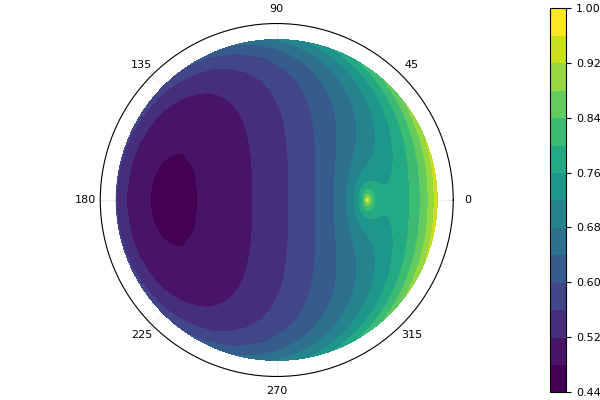

In [108]:
hm = contourf(deg2rad.(collect((0:360))),collect(0:1:85),  SIFFER, proj=:polar, color=:viridis)

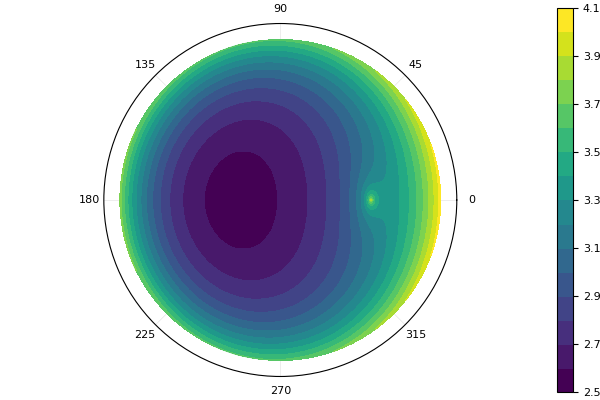

In [109]:
hm = contourf(deg2rad.(collect((0:360))),collect(0:1:85),  SIFFER_FR, proj=:polar, color=:viridis)

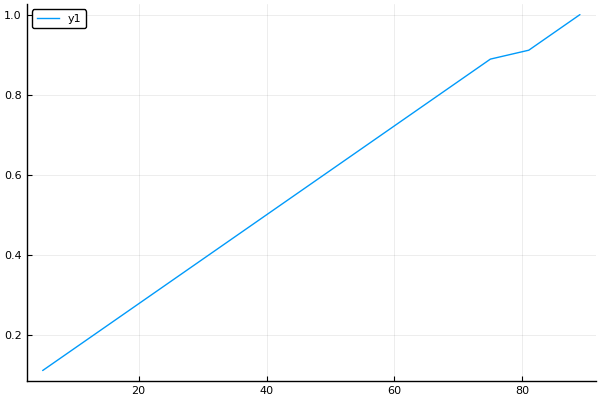

In [110]:
plot(CanopyRTMod.litab, cumsum(canopy.lidf))

In [82]:
litab_bnd  = FT[[0.,10.,20.,30.,40.,50.,60.,70.,80.,82.,84.,86.,88.] [10.,20.,30.,40.,50.,60.,70.,80.,82.,84.,86.,88., 90.] ];

In [111]:
cumsum(canopy.lidf)

13-element Array{Float32,1}:
 0.111111104
 0.22222221
 0.33333334
 0.44444442
 0.5555556
 0.6666667
 0.7777778
 0.8888889
 0.9111111
 0.93333334
 0.9555555
 0.9777777
 0.99999994